# **PROBLEM STATEMENT**
## Banks face challenges in understanding and segmenting their customer base effectively, leading to generalized marketing efforts that lack personalization and relevance. This results in lower engagement and conversion rates as products and services may not meet specific customer needs. Additionally, without clear segmentation, banks struggle to optimize resource allocation and service delivery channels, potentially causing inefficiencies and customer dissatisfaction. 

# **Analytics Solution**
## The possible solution might be using K-means clustering to segment customers based on financial behaviors, aiding in targeted marketing and personalized service offerings. This enables better understanding of customer needs, optimizing resource allocation and improving overall customer satisfaction and retention.

# Data Used

In [2]:
 df = spark.read.parquet('hdfs://localhost:9000/ingest/ml_dataset/gsa_lam_demo_int_table')

In [3]:
df.show(5)

24/06/24 04:34:48 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+----------------+-----------+---------+-----+----------------+---------------+---------------+--------+------+---------+---------+--------------+--------------------+-------------+-------------+----------------+-------------+--------+--------------+--------------------+-----------------+----------+----------------+---------+---------------+----------------+------+----------------+--------------------+---------+----------+---------+--------------+-------+---------+-------------------------+---------------------------+------------+--------------------+--------------------+----------+----------+------+--------------------+---------+----------+-------------+-------------+--------------+-----------------+-------------+--------------------+--------------------+------------------------+--------------------+-------------------+---------------+----------------------------+------------------+--------------------+--------------+--------------------+--------------------+----------------

# Exploratory Data Analysis(EDA)
## 1. Feature Engineering

In [4]:
# The gender column is 

In [5]:
data=df.groupby('gender').count()
data.show()

+------+------+
|gender| count|
+------+------+
|     F|114272|
|     M|206216|
|     O|   192|
+------+------+



In [6]:
data=df.groupby('salutation').count()
data.show()

+----------+------+
|salutation| count|
+----------+------+
|       MS.| 10744|
|      MRS.|103480|
|      MISS|  1904|
|       MR.|204496|
|      MAST|    40|
|       M/S|    16|
+----------+------+



In [7]:
data=df.groupby('employment_status').count()
data.show()

+-----------------+------+
|employment_status| count|
+-----------------+------+
|         Employed|108008|
|         Salaried| 67224|
|            Other| 93336|
|        Housewife| 28056|
|          Retired|  5640|
|       Unemployed| 18400|
|             null|    16|
+-----------------+------+



In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Initialize Spark session
spark = SparkSession.builder.appName("GenderUpdate").getOrCreate()


# Update gender based on salutation
df = df.withColumn(
    'gender',
    when(col('salutation') == 'MR.', 'Male')
    .when(col('salutation') == 'MRS.', 'Female')
    .when(col('salutation') == 'MS.', 'Female')
    .when(col('salutation') == 'MAST', 'Male')
    .when(col('salutation') == 'MISS', 'Female')
    .when(col('salutation') == 'M/S', 'org')
    .otherwise(col('gender'))
)

# # Show the updated DataFrame
# df.show()


### Calculate kyc_flag on the basis of kyc_date,whether it is null or not.

In [9]:
from pyspark.sql.functions import when, col
df = df.withColumn("kyc_flag", when(col("kyc_date").isNotNull(), 1).otherwise(0))
df.select("kyc_flag").show()

+--------+
|kyc_flag|
+--------+
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
+--------+
only showing top 20 rows



### Calculated age of customer on the basis of column cust_dob

In [10]:
from pyspark.sql.functions import col, current_date, datediff, floor

# Calculate age
df = df.withColumn('cust_age', floor(datediff(current_date(), col('cust_dob')) / 365.25))

# Show the updated DataFrame
df.select('cust_dob','cust_age').show(10)


+--------------------+--------+
|            cust_dob|cust_age|
+--------------------+--------+
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1980-06-14 00:00:...|      44|
|1992-11-01 00:00:...|      31|
|1992-11-01 00:00:...|      31|
+--------------------+--------+
only showing top 10 rows



### Categorized the (occupation,schm_desc)column and keep top 10 priorities ,put left category into others.


In [11]:
from pyspark.sql import functions as F

# Group by 'occupation' and count occurrences
data = df.groupBy('occupation').count()

# Order by count in descending order
data = data.orderBy(F.desc('count'))

# Get the top 10 categories
top_10_categories = [row['occupation'] for row in data.limit(10).collect()]

# Create a new column 'category_occ' with 'occupation' if it's in the top 10, otherwise mark as 'Other'
data = data.withColumn('category_occ', F.when(F.col('occupation').isin(top_10_categories), F.col('occupation')).otherwise('OTHER'))

# Group by 'category_occ' and sum counts
grouped_data = data.groupBy('category_occ').agg(F.sum('count').alias('total_count'))

# Combine null and "Other" categories
combined_count = grouped_data.filter((F.col('category_occ').isNull()) | (F.col('category_occ') == 'OTHER')) \
                             .agg(F.sum('total_count').alias('total_count')).collect()[0]['total_count']

# Filter out null and "Other" rows, then add a new row for the combined "Other" category
grouped_data = grouped_data.filter(~((F.col('category_occ').isNull()) | (F.col('category_occ') == 'OTHER'))) \
                           .union(df.sql_ctx.createDataFrame([('OTHER', combined_count)], ['category_occ', 'total_count']))

# Show the result
grouped_data.orderBy(F.desc('total_count')).show(10)

# Join the grouped_data with df, renaming the column to avoid ambiguity
df = df.join(data.select('occupation', 'category_occ'), on='occupation', how='left') \
       .withColumnRenamed('category_occ', 'category_occ_type')

# Replace null values with 'Other'
df = df.withColumn('category_occ', F.when(F.col('category_occ_type').isNull(), 'OTHER').otherwise(F.col('category_occ_type')))

# Drop the temporary 'category_occ_type' column if not needed
df = df.drop('category_occ_type')

# Show the modified df DataFrame
#df.show()


+------------+-----------+
|category_occ|total_count|
+------------+-----------+
|       SALPN|      67384|
|        AGRI|      66424|
|       BUSIN|      57104|
|       OTHER|      54704|
|        HMMK|      35272|
|       SELFE|      22928|
|       STUDT|       5104|
|       RETIR|       5104|
|       NARMY|       3728|
|       FOREM|       2928|
+------------+-----------+



In [12]:
from pyspark.sql import functions as F

# Group by 'schm_desc' and count occurrences
data = df.groupBy('schm_desc').count()

# Order by count in descending order
data = data.orderBy(F.desc('count'))

# Get the top 10 categories
top_10_categories = [row['schm_desc'] for row in data.limit(10).collect()]

# Create a new column 'category_schm_desc' with 'schm_desc' if it's in the top 10, otherwise mark as 'Other'
data = data.withColumn('category_schm', F.when(F.col('schm_desc').isin(top_10_categories), F.col('schm_desc')).otherwise('Other'))

# Group by 'category_schm_desc' and sum counts
grouped_data = data.groupBy('category_schm').agg(F.sum('count').alias('total_count'))

# Show the result
grouped_data.orderBy(F.desc('total_count')).show(10)

# Join the grouped_data with df
df = df.join(data.select('schm_desc', 'category_schm'), on='schm_desc', how='left')

# Show the modified df DataFrame
# df.show()




+--------------------+-----------+
|       category_schm|total_count|
+--------------------+-----------+
|LOAN AGAINST PROP...|      71520|
|           HOME LOAN|      63824|
|    LOAN AGAINST FDR|      37032|
|      EDUCATION LOAN|      36176|
|               Other|      34104|
|  HIRE PURCHASE LOAN|      16784|
|MF DIRECT LENDING-TL|      16760|
|          OTHER LOAN|      13376|
|STAFF HOUSING LOA...|      11176|
|           AUTO LOAN|      10744|
+--------------------+-----------+
only showing top 10 rows



### Drop Duplicate Data

In [13]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SelectAndSaveToCSV") \
    .getOrCreate()

# Select specific columns
selected_columns_df = df.select(
    'annual_others_income',
    'totalhouseholdincm',
    'cust_age',
    'category_occ',
    'category_schm',
    'annual_salary_income',
    'employment_status',
    'employersname',
    'income_nature',
    'riskrating',
    'marital_status',
    'annual_total_income',
    'dis_amt',
    'kyc_flag'
)

#selected_columns_df.show()

selected_columns_df.write.csv('selected_data.csv', header=True, mode='overwrite')




In [14]:
# selected_columns_df.count()

In [15]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("DropDuplicates") \
    .getOrCreate()


df = spark.read.csv('selected_data.csv', header=True, inferSchema=True)

# Drop duplicate rows based on all columns
df_no_duplicates = df.dropDuplicates()








In [16]:
# df_no_duplicates.count()

In [17]:
df_no_duplicates.show(5)

+--------------------+------------------+--------+------------+--------------------+--------------------+-----------------+-------------+-------------+----------+--------------+-------------------+----------+--------+
|annual_others_income|totalhouseholdincm|cust_age|category_occ|       category_schm|annual_salary_income|employment_status|employersname|income_nature|riskrating|marital_status|annual_total_income|   dis_amt|kyc_flag|
+--------------------+------------------+--------+------------+--------------------+--------------------+-----------------+-------------+-------------+----------+--------------+-------------------+----------+--------+
|                 0.0|         1100000.0|      33|       SELFE|  HIRE PURCHASE LOAN|            500000.0|         Employed|SELF EMPLOYED|          001|       LOW|             M|          1100000.0| 828241.28|       1|
|                null|              null|      39|       OTHER|STAFF HOUSING LOA...|                 1.0|            Other|     

In [18]:
selected_df=df_no_duplicates.fillna('Other')


In [33]:
data=selected_df.groupby('employment_status').count()
#data.show()

In [20]:
# from pyspark.sql import SparkSession

# # Initialize Spark session
# spark = SparkSession.builder \
#     .appName("UniqueCategories") \
#     .getOrCreate()


# # List of columns to find unique categories
# columns_of_interest = [
#     'totalhouseholdincm',
#     'cust_age',
#     'category_occ',
#     'category_schm',
#     'annual_salary_income',
#     'employment_status',
#     'employersname',
#     'income_nature',
#     'riskrating',
#     'marital_status',
#     'annual_total_income',
#     'kyc_flag',
#     'dis_amt'
# ]

# # Iterate through the columns and print unique values for each in descending order
# for column in columns_of_interest:
#     unique_values = selected_df.select(column).distinct().orderBy(column, ascending=False).rdd.flatMap(lambda x: x).collect()
#     print(f"Unique values in column '{column}' (sorted in descending order):\n{unique_values}\n")

###  Remove '.' and '-' from employersname

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Clean Data") \
    .getOrCreate()


# Remove rows with None in specific columns
cleaned_df = df.filter(
    col("totalhouseholdincm").isNotNull() & 
    col("annual_salary_income").isNotNull()
)

# Remove '.' and '-' from employersname
cleaned_df = selected_df.withColumn(
    "employersname",
    regexp_replace(col("employersname"), "[.-]", "")
)

cleaned_df.show(5)


+--------------------+------------------+--------+------------+--------------------+--------------------+-----------------+-------------+-------------+----------+--------------+-------------------+----------+--------+
|annual_others_income|totalhouseholdincm|cust_age|category_occ|       category_schm|annual_salary_income|employment_status|employersname|income_nature|riskrating|marital_status|annual_total_income|   dis_amt|kyc_flag|
+--------------------+------------------+--------+------------+--------------------+--------------------+-----------------+-------------+-------------+----------+--------------+-------------------+----------+--------+
|                 0.0|         1100000.0|      33|       SELFE|  HIRE PURCHASE LOAN|            500000.0|         Employed|SELF EMPLOYED|          001|       LOW|             M|          1100000.0| 828241.28|       1|
|                null|              null|      39|       OTHER|STAFF HOUSING LOA...|                 1.0|            Other|     

In [22]:
# from pyspark.sql import SparkSession

# # Initialize Spark session
# spark = SparkSession.builder \
#     .appName("UniqueCategories") \
#     .getOrCreate()


# # List of columns to find unique categories
# columns_of_interest = [
#     'totalhouseholdincm',
#     'cust_age',
#     'category_occ',
#     'category_schm',
#     'annual_salary_income',
#     'employment_status',
#     'employersname',
#     'income_nature',
#     'riskrating',
#     'marital_status',
#     'annual_total_income',
#     'kyc_flag',
#     'dis_amt'
# ]

# # Iterate through the columns and print unique values for each in descending order
# for column in columns_of_interest:
#     unique_values = cleaned_df.select(column).distinct().orderBy(column, ascending=False).rdd.flatMap(lambda x: x).collect()
#     print(f"Unique values in column '{column}' (sorted in descending order):\n{unique_values}\n")

### Change the datatypes in required format

In [23]:
cleaned_df = selected_df.withColumn("dis_amt", col("dis_amt").cast("double"))

In [24]:
# cleaned_df.count() 

In [25]:
df = cleaned_df.na.drop(subset=[ 'totalhouseholdincm', 'cust_age', 'category_occ', 'category_schm',
        'annual_salary_income', 'employment_status', 'employersname',
        'income_nature', 'riskrating', 'marital_status', 'annual_total_income',
        'kyc_flag', 'dis_amt'])

### Removes rows where annual_salary_income, annual_total_income, or totalhouseholdincm contain values in scientific notation (e.g., 1.23E+05)

In [26]:
df = df.filter(~df.annual_salary_income.rlike(r'[0-9\.]+E[+-]?[0-9]+'))
df = df.filter(~when(df.annual_total_income == 1, True).otherwise(False))
df = df.filter(~when(df.totalhouseholdincm == 1, True).otherwise(False))
df = df.filter(~df.annual_total_income.rlike(r'[0-9\.]+E[+-]?[0-9]+'))
df = df.filter(~df.totalhouseholdincm.rlike(r'[0-9\.]+E[+-]?[0-9]+'))

### convert categorical data into categorical values using stringindexer('cust_age', 'category_occ', 'category_schm','employment_status','income_nature', 'riskrating', 'marital_status', 'kyc_flag')

In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder \
    .appName("StringIndexer Example") \
    .getOrCreate()


# Apply StringIndexer
indexer = StringIndexer(
    inputCols=[
         'cust_age', 'category_occ', 'category_schm',
        'employment_status', 
        'income_nature', 'riskrating', 'marital_status', 
        'kyc_flag'
    ],
    outputCols=[
        'cust_age_index', 'category_occ_index', 'category_schm_index',
 'employment_status_index', 
        'income_nature_index', 'riskrating_index', 'marital_status_index', 
        'kyc_flag_index'
    ]
).fit(df)
# Transform the DataFrame
indexed_df = indexer.transform(df)

# Rearrange columns to place indexed columns next to their original columns
final_columns = []
for col_name in df.columns:
    final_columns.append(col_name)
    if col_name in indexer.getInputCols():
        final_columns.append(col_name + "_index")

# Select the columns in the desired order
indexed_df = indexed_df.select(final_columns)
indexed_df.show(5)


+--------------------+------------------+--------+--------------+------------+------------------+--------------------+-------------------+--------------------+-----------------+-----------------------+-------------+-------------+-------------------+----------+----------------+--------------+--------------------+-------------------+----------+--------+--------------+
|annual_others_income|totalhouseholdincm|cust_age|cust_age_index|category_occ|category_occ_index|       category_schm|category_schm_index|annual_salary_income|employment_status|employment_status_index|employersname|income_nature|income_nature_index|riskrating|riskrating_index|marital_status|marital_status_index|annual_total_income|   dis_amt|kyc_flag|kyc_flag_index|
+--------------------+------------------+--------+--------------+------------+------------------+--------------------+-------------------+--------------------+-----------------+-----------------------+-------------+-------------+-------------------+----------+--


## 2 . Elbow Method: The elbow method helps identify the optimal k by plotting the WCSS against the number of clusters. The point where the WCSS starts to decrease more slowly (forming an elbow shape) suggests the optimal k value where adding more clusters does not significantly reduce WCSS.
### Understanding the Elbow Method:
### WCSS (Within-Cluster Sum of Squares): It is a measure of the total variance within each cluster. As the number of clusters increases, WCSS typically decreases as clusters become smaller and more specific.
### Number of Clusters (k): This is the number of clusters the data points are divided into
### Interpreting the Graph:
 ### Left of the Elbow (2-3 clusters): Significant decrease in WCSS, indicating that adding clusters improves the model significantly.
 ### At the Elbow (around 3 clusters): The point where the rate of decrease sharply slows down.
 ### Right of the Elbow (4-9 clusters): WCSS continues to decrease but at a much slower rate, indicating diminishing returns with the addition of more clusters.

### The Elbow Method graph helps in choosing the optimal number of clusters by looking for the point where the reduction in WCSS slows down noticeably, forming an "elbow" shape. In this case, the optimal number of clusters appears to be around 3.

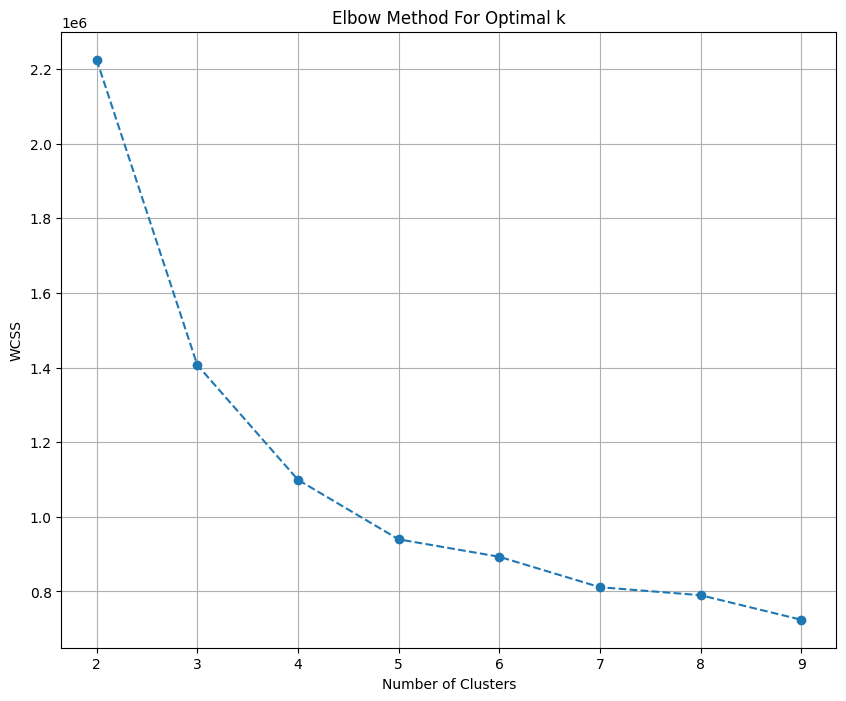

In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("KMeans Elbow Method").getOrCreate()



# Specify numerical and categorical columns
numerical_cols = [
    'annual_others_income',
 'totalhouseholdincm',
 'annual_salary_income',
 'annual_total_income',
 'dis_amt',
 'kyc_flag',
]

categorical_cols = [

'cust_age_index','category_occ_index', 'category_schm_index','employment_status_index','income_nature_index', 'riskrating_index','marital_status_index', 'kyc_flag'
]

# Assemble numerical columns into a feature vector
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
assembled_data_num = assembler_num.transform(indexed_df)

# Scale the numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
scaler_model = scaler.fit(assembled_data_num)
scaled_data_num = scaler_model.transform(assembled_data_num)

# Combine scaled numerical features with categorical features
assembler_all = VectorAssembler(inputCols=['scaled_numerical_features'] + categorical_cols, outputCol="features")
final_data = assembler_all.transform(scaled_data_num)

# Elbow method to find the optimal number of clusters
wcss = []
k_values = range(2, 10)  # Start k from 2 instead of 1

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol='features')
    model = kmeans.fit(final_data)
    wcss.append(model.summary.trainingCost)

# Plot the elbow method graph
plt.figure(figsize=(10, 8))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()


# Input variable Used

In [39]:
indexed_df.select('annual_others_income',
 'totalhouseholdincm',
 'cust_age',
 'category_occ_index',
 'category_schm_index',
 'annual_salary_income',
 'employment_status_index',
 'employersname',
 'income_nature_index',
 'riskrating_index',
 'marital_status_index',
 'annual_total_income',
 'dis_amt',
 'kyc_flag',
 ).show(5)

+--------------------+------------------+--------+------------------+-------------------+--------------------+-----------------------+-------------+-------------------+----------------+--------------------+-------------------+----------+--------+
|annual_others_income|totalhouseholdincm|cust_age|category_occ_index|category_schm_index|annual_salary_income|employment_status_index|employersname|income_nature_index|riskrating_index|marital_status_index|annual_total_income|   dis_amt|kyc_flag|
+--------------------+------------------+--------+------------------+-------------------+--------------------+-----------------------+-------------+-------------------+----------------+--------------------+-------------------+----------+--------+
|                 0.0|         1100000.0|      33|               4.0|                6.0|            500000.0|                    0.0|SELF EMPLOYED|                0.0|             1.0|                 0.0|          1100000.0| 828241.28|       1|
|           

## **Model Preperation:**
 
### **1: VectorAssembler to transform feature columns into a single vector column named "features".**
### **2: Data Normalization:**
   ### Data normalization is a preprocessing step used to rescale feature values to a common range, typically [0, 1] or [-1, 1]
### **3: Splitting the data into 80% training and 20% testing sets.**
### **4: Principal Component Analysis (PCA) :**
  ### Reduce the dimensionality of a dataset
### **5: Model:**
### K-means Clustering
### **6: Number of clusters (k): 3**

In [41]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import rand


# Create a SparkSession
spark = SparkSession.builder.appName("Customer_segmentation").getOrCreate()


# List of numerical and categorical feature columns
numerical_cols = [ 'annual_others_income',
 'totalhouseholdincm',
 'annual_salary_income',
 'annual_total_income',
 'dis_amt']
categorical_cols = ['cust_age_index','category_occ_index', 'category_schm_index','employment_status_index','income_nature_index', 'riskrating_index','marital_status_index', 'kyc_flag']

# Assemble the numerical features
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
assembled_data_num = assembler_num.transform(indexed_df)

# Normalize the numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled_data_num)
scaled_data_num = scaler_model.transform(assembled_data_num)

# Combine the scaled numerical features with categorical features
assembler_all = VectorAssembler(inputCols=['scaled_numerical_features'] + categorical_cols, outputCol="features")
final_data = assembler_all.transform(scaled_data_num)

# Split the data into training and testing sets
final_data = final_data.withColumn("rand", rand())
final_data = final_data.orderBy("rand")
training_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(training_data)
training_data_pca = pca_model.transform(training_data)
test_data_pca = pca_model.transform(test_data)

# Train the K-Means model on the PCA-transformed data
kmeans = KMeans(k=3, featuresCol="pca_features", predictionCol="cluster")
kmeans_model = kmeans.fit(training_data_pca)



# Prediction Part

In [40]:
# Use the model for predictions on the PCA-transformed test data
predictions = kmeans_model.transform(test_data_pca)

# Show some predictions
predictions.select('scaled_numerical_features','features','pca_features', 'cluster').show()

+-------------------------+--------------------+--------------------+-------+
|scaled_numerical_features|            features|        pca_features|cluster|
+-------------------------+--------------------+--------------------+-------+
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[32.0795135498149...|      2|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[18.0764796201206...|      0|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[13.0603446511827...|      0|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[13.1028899643870...|      0|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[12.1222441386587...|      1|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[8.07186341387893...|      1|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[8.10292100983465...|      1|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[11.1081414416708...|      1|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[11.1138670789688...|      1|
|     [0.0,1.3486479813...|[0.0,1.3486479813...|[3.0990483266013

### Use Spark SQL to count the occurrences of each unique value in the 'cluster' column

In [30]:
# Register the DataFrame as a temporary view
predictions.createOrReplaceTempView("predictions")

# Use Spark SQL to count the occurrences of each unique value in the 'cluster' column
unique_counts = spark.sql("SELECT cluster, COUNT(*) AS count FROM predictions GROUP BY cluster")

# Show the result
unique_counts.show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 3897|
|      2| 1593|
|      0| 3355|
+-------+-----+



## **Model Evaluation**
### A higher silhouette score indicates better-defined clusters, with points in the same cluster being more similar to each other than to points in other clusters.A silhouette score of 0.69 indicates that the clustering model has achieved a reasonably good separation between clusters. Here’s what the silhouette score generally signifies:


In [31]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate the model using silhouette score
evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="pca_features", metricName="silhouette")
silhouette_score = evaluator.evaluate(predictions)

print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.684522623318644


### Visualization of Cluster with Centroid

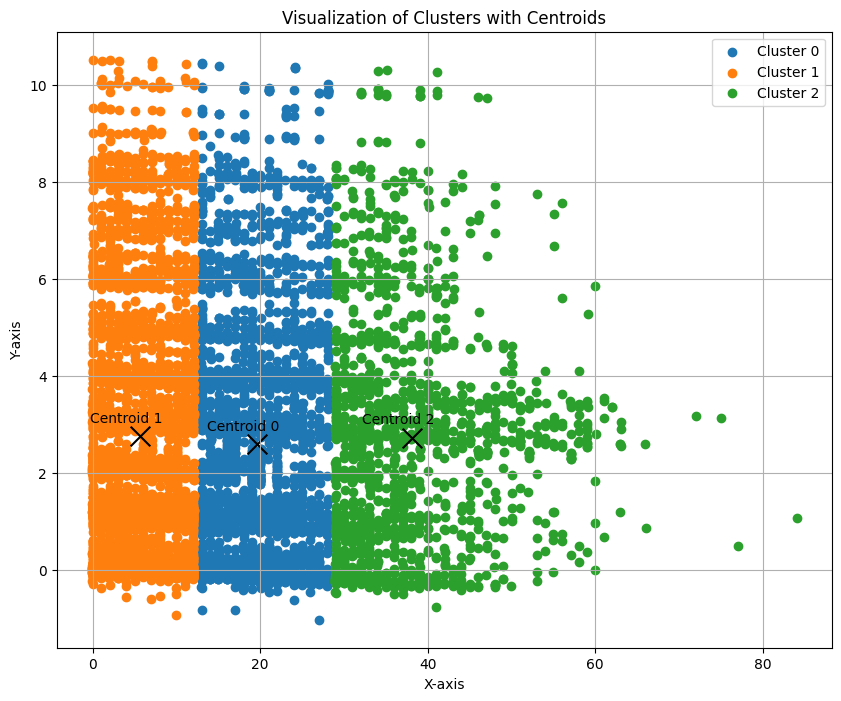

In [32]:
import numpy as np

# Extract features and cluster assignments from predictions DataFrame
features = predictions.select("pca_features").collect()
clusters = predictions.select("cluster").collect()

x_values = [feature[0][0] for feature in features]
y_values = [feature[0][1] for feature in features]

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_x = [x_values[j] for j in range(len(clusters)) if clusters[j][0] == i]
    cluster_y = [y_values[j] for j in range(len(clusters)) if clusters[j][0] == i]
    plt.scatter(cluster_x, cluster_y, label=f'Cluster {i}')

    # Compute the centroid of the current cluster
    centroid_x = np.mean(cluster_x)
    centroid_y = np.mean(cluster_y)
    plt.scatter(centroid_x, centroid_y, color='black', marker='x', s=200)  # Mark centroid with a black 'x'

    # Annotate the centroid with its cluster number
    plt.annotate(f'Centroid {i}', (centroid_x, centroid_y), textcoords="offset points", xytext=(-10,10), ha='center')

plt.title('Visualization of Clusters with Centroids')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


### **EDA: Calculates the mean of numerical features and the mode (most frequent value) of categorical features for each cluster.**

In [44]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, count, desc, mean, first
 
# Initialize Spark session
spark = SparkSession.builder.appName("KMeans Clustering Mean and Mode").getOrCreate()
 
 

 
# Specify the input columns
input_columns = [
    'cust_age_index','category_occ_index', 'category_schm_index','employment_status_index','income_nature_index', 'riskrating_index','marital_status_index', 'kyc_flag',
    'annual_others_income',
 'totalhouseholdincm',
 'annual_salary_income',
 'annual_total_income',
 'dis_amt'
 
]
 
# Assemble input columns into a feature vector
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
assembled_data = assembler.transform(indexed_df)
 
# Scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)
 
# Apply K-means clustering
kmeans = KMeans(k=3, seed=42, featuresCol='scaled_features')
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)
 
# Select numerical and categorical columns
numerical_columns = [
 'annual_others_income',
 'totalhouseholdincm',
 'annual_salary_income',
 'annual_total_income',
 'dis_amt',]
categorical_columns = [
  'cust_age_index','category_occ_index', 'category_schm_index','employment_status_index','income_nature_index', 'riskrating_index','marital_status_index', 'kyc_flag'  
]
 
# Calculate mean for numerical columns within each cluster
mean_df = predictions.groupBy("prediction").agg(
    *[mean(col).alias(f'mean_{col}') for col in numerical_columns]
)
 
# Show mean results
mean_df.show()
 
# Calculate mode for categorical columns within each cluster
for col_name in categorical_columns:
    mode_df = predictions.groupBy("prediction", col_name).agg(count(col_name).alias('count')) \
        .orderBy('prediction', desc('count')) \
        .groupBy("prediction") \
        .agg(first(col_name).alias(f'mode_{col_name}'))
 
    # Show mode results
    mode_df.show()
 
# Merge mean and mode results
result_df = mean_df
for col_name in categorical_columns:
    mode_df = predictions.groupBy("prediction", col_name).agg(count(col_name).alias('count')) \
        .orderBy('prediction', desc('count')) \
        .groupBy("prediction") \
        .agg(first(col_name).alias(f'mode_{col_name}'))
 
    result_df = result_df.join(mode_df, on="prediction")
 
# Show final result
#result_df.show()

+----------+-------------------------+-----------------------+-------------------------+------------------------+------------------+
|prediction|mean_annual_others_income|mean_totalhouseholdincm|mean_annual_salary_income|mean_annual_total_income|      mean_dis_amt|
+----------+-------------------------+-----------------------+-------------------------+------------------------+------------------+
|         1|         8.00640512409928|       969040.224723779|       316112.64173859084|        969044.227926341|1600268.9964907924|
|         2|                1500000.0|              3011000.0|                  11000.0|               3011000.0|         706916.79|
|         0|                      0.0|     4081737.8591170823|       1249638.9990710171|      4081737.8591170823|3520139.3628925183|
+----------+-------------------------+-----------------------+-------------------------+------------------------+------------------+

+----------+-------------------+
|prediction|mode_cust_age_index|
+-

+----------+------------------------+
|prediction|mode_income_nature_index|
+----------+------------------------+
|         1|                     0.0|
|         2|                     1.0|
|         0|                     0.0|
+----------+------------------------+

+----------+---------------------+
|prediction|mode_riskrating_index|
+----------+---------------------+
|         1|                  0.0|
|         2|                  1.0|
|         0|                  0.0|
+----------+---------------------+

+----------+-------------------------+
|prediction|mode_marital_status_index|
+----------+-------------------------+
|         1|                      0.0|
|         2|                      0.0|
|         0|                      0.0|
+----------+-------------------------+

+----------+-------------+
|prediction|mode_kyc_flag|
+----------+-------------+
|         1|            1|
|         2|            0|
|         0|            0|
+----------+-------------+



## **Business Translation**
 
### **1: For Marketing:**
   #### Tailor ads to match the interests and preferences of each customer group.
### **2: For Product Development:**
   #### Create or modify products to better meet the needs of each segment.
### **3: For Risk Management:**
 #### Identify which groups might be risky and adjust lending policies accordingly.
### **4: For Customer Service:**
 #### Provide the best services for each group, making banking easier and more enjoyable for everyone.